In [261]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [262]:
# Read data from file
# Change labels to 0, 1
df = pd.read_excel('anger.xlsx')
df.rename(columns={'Unnamed: 0':'participant'}, inplace=True) # add name to first column
df = df.drop(columns=['participant', 'Video'])
df.loc[df["Label"] == "Genuine", "Label"] = 0
df.loc[df["Label"] == "Posed", "Label"] = 1
df["Label"] = df["Label"].astype(np.long)

In [263]:
df.describe()

,Mean,Std,Diff1,Diff2,PCAd1,PCAd2,Label
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.889090,0.102462,0.008421,0.209575,0.030703,0.121382,0.500000
std,0.058538,0.083080,0.008153,0.097787,0.014715,0.029972,0.500626
min,0.582885,0.007986,0.001081,0.021851,0.010325,0.061143,0.000000
25%,0.852057,0.040081,0.002415,0.114244,0.019492,0.104173,0.000000
50%,0.897453,0.068729,0.004292,0.234337,0.028206,0.117531,0.500000
75%,0.934203,0.159266,0.013236,0.290046,0.035855,0.137517,1.000000
max,0.983422,0.358368,0.044005,0.418234,0.083780,0.239318,1.000000


In [264]:
# Preprocessing 
# Normalise data [-1, 1]
normalised_df = (df-df.min()) * 2 /(df.max()-df.min()) - 1
normalised_df.loc[normalised_df["Label"] == -1, "Label"] = 0

In [265]:
normalised_df.describe()

,Mean,Std,Diff1,Diff2,PCAd1,PCAd2,Label
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.528973,-0.460726,-0.657998,-0.052818,-0.445152,-0.323827,0.500000
std,0.292300,0.474227,0.379878,0.493398,0.400649,0.336435,0.500626
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.344055,-0.816805,-0.937877,-0.533818,-0.750414,-0.516995,0.000000
50%,0.570731,-0.653277,-0.850394,0.072124,-0.513152,-0.367047,0.500000
75%,0.754234,-0.136488,-0.433674,0.353212,-0.304882,-0.142716,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [266]:
# Split dataset into training set and test set
train_data, test_data = train_test_split(normalised_df, test_size=0.2, shuffle=True)
num_features = train_data.shape[1] - 1

# split training data into input and target
# the last column is target and the rest are features
train_input = train_data.iloc[:, :-1,]
train_target = train_data.iloc[:, -1:,]

# split test data into input and target
# the last column is target and the rest are features
test_input = test_data.iloc[:, :-1,]
test_target = test_data.iloc[:, -1::]

# # create Tensors to hold inputs and outputs
X = torch.from_numpy(train_input.values).float().to(device)
Y = torch.from_numpy(train_target.values).long().squeeze().to(device)

X_test = torch.from_numpy(test_input.values).float().to(device)
Y_test = torch.from_numpy(test_target.values).long().squeeze().to(device)

# -- Train Model --
# define the number of inputs, classes, training epochs, and learning rate
input_neurons = X.shape[1]
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.01
num_epoch = 5000

neurons_to_prune = []
best_validation_loss = []
test_accuracy = []
train_loss = []
valid_loss = []
total_epoch = 0

In [267]:
# define a customised neural network structure
class TwoLayerNet(nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        # self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        self.fc1.weight.data[neurons_to_prune] = 0
        self.fc1.bias.data[neurons_to_prune] = 0
        self.fc2.weight.data.T[neurons_to_prune] = 0
        h_input = self.fc1(x)
        h_output = torch.sigmoid(h_input)
        self.acts1 = h_output
        y_pred = self.fc2(h_output)
        return y_pred
    
# define a neural network using the customised structure 
model = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)
# model = model.cuda()
# define loss function (https://pytorch.org/docs/stable/nn.html#loss-functions)
loss_func = torch.nn.CrossEntropyLoss()


# define optimiser (https://pytorch.org/docs/stable/optim.html)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimiser, 'min', factor = 0.5, patience = 10, min_lr=0.001)

In [268]:
# Train a neural network until convergence

patience = 50 # for early stopping
for epoch in range(num_epoch):
    # Set model to training mode
    model.train()
    
    optimiser.zero_grad(set_to_none=True)
    Y_pred = model(X)
    loss = loss_func(Y_pred, Y)
    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())
    
   
     # Set model to evaluation mode
    model.eval()
    Y_pred_test = model(X_test)
    loss = loss_func(Y_pred_test, Y_test)
    valid_loss.append(loss.item())
    
    curr_lr = optimiser.param_groups[0]['lr']
    
    if epoch % 50 == 0 or epoch+1 == num_epoch:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.eq(Y).long().sum()
        print('Epoch [%d] Training Loss: %.4f Validation Loss: %.4f LR: %.4f  Training Accuracy: %.2f %%'
              % (total_epoch + 1, train_loss[len(train_loss)-1], valid_loss[len(valid_loss)-1], curr_lr, 100 * correct/total))
        
    scheduler.step(loss.item())
    
    if loss.item() == min(valid_loss):
        torch.save({
                    'epoch': total_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'loss': loss.item(),
                    'neurons_to_prune': neurons_to_prune,
                    }, "best20.pt")
    total_epoch += 1
    if epoch > 200 and loss.item() > valid_loss[len(valid_loss) - patience]:
        break

# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
model.eval()
Y_pred_test = model(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(Y_pred_test, 1)

# calculate accuracy
total_test = predicted_test.size(0)
correct_test = predicted_test.eq(Y_test).long().sum()

print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))

Epoch [1] Training Loss: 0.8015 Validation Loss: 0.7093 LR: 0.0100  Training Accuracy: 48.75 %
Epoch [51] Training Loss: 0.6925 Validation Loss: 0.6977 LR: 0.0010  Training Accuracy: 51.25 %
Epoch [101] Training Loss: 0.6912 Validation Loss: 0.6966 LR: 0.0010  Training Accuracy: 47.81 %
Epoch [151] Training Loss: 0.6899 Validation Loss: 0.6969 LR: 0.0010  Training Accuracy: 51.56 %
Epoch [201] Training Loss: 0.6882 Validation Loss: 0.6973 LR: 0.0010  Training Accuracy: 53.44 %
Testing Accuracy: 48.75 %


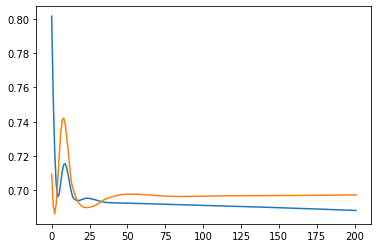

In [269]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()

In [270]:
neurons_to_prune = []

# Load best model 
def test_best_model(file):

    model = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)
    # model = model.cuda()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    checkpoint = torch.load(file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    neurons_to_prune = checkpoint['neurons_to_prune']

    best_validation_loss.append(loss)
    model.eval()
    Y_pred_test = model(X_test)

    print("validation loss: %f" % loss)
    # get prediction
    # convert three-column predicted Y values to one column for comparison
    _, predicted_test = torch.max(Y_pred_test, 1)

    print('Confusion matrix for testing:')

    # Print the confusion matrix
    print(metrics.confusion_matrix(Y_test.cpu(), predicted_test.cpu()))

    # Print the precision and recall, among other metrics
    print(metrics.classification_report(Y_test.cpu(), predicted_test.cpu(), digits=3))
    
    test_accuracy.append(100 * sum(predicted_test.data.numpy() == Y_test.data.numpy()) / predicted_test.size(0))

    
test_best_model("best20.pt")

validation loss: 0.686217
Confusion matrix for testing:
[[44  0]
 [36  0]]
              precision    recall  f1-score   support

           0      0.550     1.000     0.710        44
           1      0.000     0.000     0.000        36

    accuracy                          0.550        80
   macro avg      0.275     0.500     0.355        80
weighted avg      0.303     0.550     0.390        80



D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Implement technique

## Neuron activation vectors

In [271]:
min_angles_neuron = []
neurons_to_prune = []
best_validation_loss = []
test_accuracy = []
total_epoch = epoch
# train_loss = []
# valid_loss = []

In [272]:
def prune_neuron_output_activation_vector(model):
    acts1 = model.acts1.detach().clone()
    acts1 = acts1.T
    # normalise to [-0.5, 0.5]
    acts1 -= 0.5
    vector_angle = torch.zeros(hidden_neurons, hidden_neurons)
    cos = nn.CosineSimilarity(dim=0)
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            vector_angle[i,j] = cos(acts1[i], acts1[j])
    vector_angle = torch.arccos(vector_angle).rad2deg()
    
    # prune the most similar neuron until no neurons left
    min_angle = 180
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            if (i not in neurons_to_prune and j not in neurons_to_prune):
                if(min(vector_angle[i,j], 180 - vector_angle[i,j]) < min_angle):
                    min_angle = min(vector_angle[i,j], 180 - vector_angle[i,j])
                    to_add = i
                    to_prune = j
    if(min_angle != 180):
        if (vector_angle[to_add,to_prune] > 130):    # complementary
            neurons_to_prune.append(to_add)
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] = 0
            model.fc2.weight.data.T[to_add] = 0
            print("Pruned complementary neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        elif(vector_angle[to_add,to_prune] < 130):    # similar
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] += model.fc1.weight.data[to_prune]
            print("Pruned similar neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        model.fc1.weight.data[to_prune] = 0
        model.fc2.weight.data.T[to_prune] = 0
    
    return min_angle
    

In [273]:
# -- Prune neural network and continue training --
new_train_loss = []
new_valid_loss = []
num_epoch = 10000

# Train a neural network until convergence
converged = True
patience = 20 # for early stopping
for epoch in range(num_epoch):
    # Set model to training mode
    model.train()
    Y_pred = model(X)
    optimiser.zero_grad(set_to_none=True)
    loss = loss_func(Y_pred, Y)
    loss.backward()
    optimiser.step()

    train_loss.append(loss.item())
    new_train_loss.append(loss.item())

    
    if converged:
        min_angle = prune_neuron_output_activation_vector(model)
        if(min_angle == 180):
            break
        min_angles_neuron.append(min_angle)
        converged = False  # change to True to not retrain after pruning

    # Set model to evaluation mode
    model.eval()
    Y_pred_test = model(X_test)
    loss = loss_func(Y_pred_test, Y_test)
    valid_loss.append(loss.item())
    new_valid_loss.append(loss.item())
    
    curr_lr = optimiser.param_groups[0]['lr']
    
    if epoch % 50 == 0 or epoch+1 == num_epoch:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.eq(Y).long().sum()
        print('Epoch [%d] Training Loss: %.4f Validation Loss: %.4f LR: %.4f  Training Accuracy: %.2f %%'
              % (total_epoch + 1, train_loss[len(train_loss)-1], valid_loss[len(valid_loss)-1], curr_lr, 100 * correct/total))
        
    scheduler.step(loss.item())
    
    if loss.item() == min(new_valid_loss):
        torch.save({
                    'epoch': total_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'loss': loss.item(),
                    'neurons_to_prune': neurons_to_prune,
                    }, "best.pt")
    total_epoch += 1
    if epoch > patience and loss.item() > new_valid_loss[len(new_valid_loss) - patience]:
        converged = True
        test_best_model("best.pt")
#         break

Pruned similar neuron pair 17 - 18 : 7.201298236846924
Epoch [202] Training Loss: 0.6882 Validation Loss: 0.6947 LR: 0.0010  Training Accuracy: 53.12 %
validation loss: 0.694685
Confusion matrix for testing:
[[15 29]
 [12 24]]
              precision    recall  f1-score   support

           0      0.556     0.341     0.423        44
           1      0.453     0.667     0.539        36

    accuracy                          0.487        80
   macro avg      0.504     0.504     0.481        80
weighted avg      0.509     0.487     0.475        80

Pruned complementary neuron pair 0 - 15 : 171.66697692871094
validation loss: 0.694685
Confusion matrix for testing:
[[16 28]
 [12 24]]
              precision    recall  f1-score   support

           0      0.571     0.364     0.444        44
           1      0.462     0.667     0.545        36

    accuracy                          0.500        80
   macro avg      0.516     0.515     0.495        80
weighted avg      0.522     0.500     

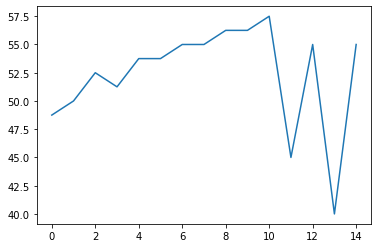

In [274]:
plt.figure()
plt.plot(test_accuracy)
plt.show()

In [275]:
print(neurons_to_prune)
print(len(neurons_to_prune))

[18, 0, 15, 1, 7, 16, 14, 2, 6, 17, 11, 19, 9, 13, 3, 12, 10, 8, 5]
19


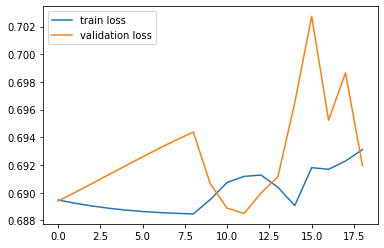

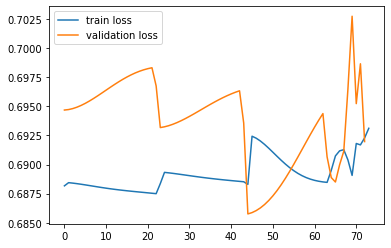

In [276]:
plt.figure()
plt.plot(train_loss[-19:], label="train loss")
plt.plot(valid_loss[-19:], label="validation loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(new_train_loss, label="train loss")
plt.plot(new_valid_loss, label="validation loss")
plt.legend()
plt.show()

In [277]:
num_neurons = [20, 19, 18, 17, 16, 15, 14, 13, 11, 9, 8, 6, 4, 3, 2, 1] # enter manually

In [278]:
best_validation_loss

[0.6946849226951599,
 0.6946849226951599,
 0.6931793093681335,
 0.6931793093681335,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108,
 0.6857589483261108]

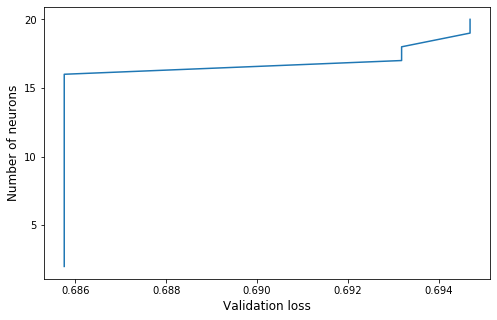

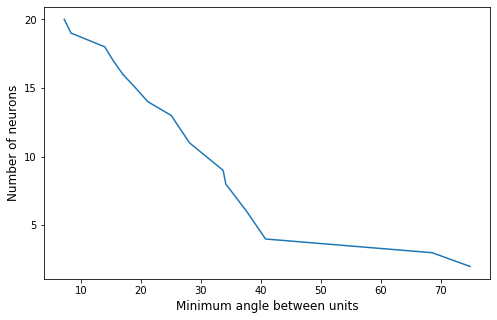

In [279]:
plt.figure(figsize=(8,5))
# plt.title("Validation loss")
plt.plot(best_validation_loss, num_neurons[:-1])
plt.xlabel("Validation loss", fontsize=12)
plt.ylabel("Number of neurons", fontsize=12)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# plt.savefig('images/neuron output - neurons vs loss.eps', dpi=50, format='eps')
plt.show()

plt.figure(figsize=(8,5))
#plt.title("Min angle")
plt.plot(min_angles_neuron, num_neurons[:-1])
plt.xlabel("Minimum angle between units", fontsize=12)
plt.ylabel("Number of neurons", fontsize=12)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# plt.savefig('images/neuron output - neurons vs min angle.eps', dpi=50, format='eps')
plt.show()


## Static weight matrix 

In [280]:
neurons_to_prune = []
best_validation_loss = []
min_angles_neuron = []
train_loss = []
valid_loss = []
test_accuracy = []
test_best_model("best20.pt")

total_epoch = epoch

validation loss: 0.686217
Confusion matrix for testing:
[[44  0]
 [36  0]]
              precision    recall  f1-score   support

           0      0.550     1.000     0.710        44
           1      0.000     0.000     0.000        36

    accuracy                          0.550        80
   macro avg      0.275     0.500     0.355        80
weighted avg      0.303     0.550     0.390        80



D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [281]:
def prune_matrix_weight_vector(model):
    w_ho = model.fc2.weight.detach().clone()
    w_ho = w_ho.T
    # normalise to [-0.5, 0.5]
    w_ho = (w_ho-w_ho.min()) /(w_ho.max()-w_ho.min()) - 0.5

    vector_angle = torch.zeros(hidden_neurons, hidden_neurons)
    cos = nn.CosineSimilarity(dim=0)
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            vector_angle[i,j] = cos(w_ho[i], w_ho[j])
    vector_angle = torch.arccos(vector_angle).rad2deg()
    
    # prune the most similar neuron
    min_angle = 180
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            # if(vector_angle[i,j] < 15  or vector_angle[i,j] > 165):
            if (i not in neurons_to_prune and j not in neurons_to_prune):
                if(min(vector_angle[i,j], 180 - vector_angle[i,j]) < min_angle):
                    min_angle = min(vector_angle[i,j], 180 - vector_angle[i,j])
                    to_add = i
                    to_prune = j
    if(min_angle != 180):
        if (vector_angle[to_add,to_prune] > 130):    # complementary
            neurons_to_prune.append(to_add)
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] = 0
            model.fc2.weight.data.T[to_add] = 0
            print("Pruned complementary neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        elif(vector_angle[to_add,to_prune] < 130):    # similar
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] += model.fc1.weight.data[to_prune]
            print("Pruned similar neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        model.fc1.weight.data[to_prune] = 0
        model.fc2.weight.data.T[to_prune] = 0
    
    return min_angle
    

In [282]:
# -- Prune neural network and continue training --
new_train_loss = []
new_valid_loss = []
num_epoch = 10000

# Train a neural network until convergence
converged = True
patience = 25 # for early stopping
for epoch in range(num_epoch):
    # Set model to training mode
    model.train()
    Y_pred = model(X)
    optimiser.zero_grad(set_to_none=True)
    loss = loss_func(Y_pred, Y)
    loss.backward()
    optimiser.step()

    train_loss.append(loss.item())
    new_train_loss.append(loss.item())

    
    if converged:
        min_angle = prune_matrix_weight_vector(model)
        if(min_angle == 180):
            break
        min_angles_neuron.append(min_angle)
        converged = False  # change to True to not retrain after pruning

    # Set model to evaluation mode
    model.eval()
    Y_pred_test = model(X_test)
    loss = loss_func(Y_pred_test, Y_test)
    valid_loss.append(loss.item())
    new_valid_loss.append(loss.item())
    
    curr_lr = optimiser.param_groups[0]['lr']
    
    if epoch % 50 == 0 or epoch+1 == num_epoch:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.eq(Y).long().sum()
        print('Epoch [%d] Training Loss: %.4f Validation Loss: %.4f LR: %.4f  Training Accuracy: %.2f %%'
              % (total_epoch + 1, train_loss[len(train_loss)-1], valid_loss[len(valid_loss)-1], curr_lr, 100 * correct/total))
        
    scheduler.step(loss.item())
    
    if loss.item() == min(new_valid_loss):
        torch.save({
                    'epoch': total_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'loss': loss.item(),
                    'neurons_to_prune': neurons_to_prune,
                    }, "best.pt")
    total_epoch += 1
    if epoch > patience and loss.item() > new_valid_loss[len(new_valid_loss) - patience]:
        converged = True
        test_best_model("best.pt")
        # break

Pruned similar neuron pair 10 - 18 : 0.0
Epoch [74] Training Loss: 0.6929 Validation Loss: 0.6930 LR: 0.0010  Training Accuracy: 50.31 %
validation loss: 0.693009
Confusion matrix for testing:
[[29 15]
 [26 10]]
              precision    recall  f1-score   support

           0      0.527     0.659     0.586        44
           1      0.400     0.278     0.328        36

    accuracy                          0.487        80
   macro avg      0.464     0.468     0.457        80
weighted avg      0.470     0.487     0.470        80

Pruned similar neuron pair 2 - 9 : 0.0
validation loss: 0.693009
Confusion matrix for testing:
[[32 12]
 [28  8]]
              precision    recall  f1-score   support

           0      0.533     0.727     0.615        44
           1      0.400     0.222     0.286        36

    accuracy                          0.500        80
   macro avg      0.467     0.475     0.451        80
weighted avg      0.473     0.500     0.467        80

Pruned similar neuro

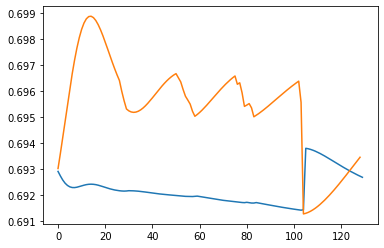

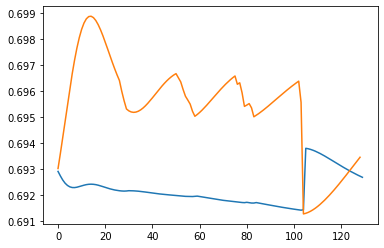

In [283]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()
plt.figure()
plt.plot(new_train_loss)
plt.plot(new_valid_loss)
plt.show()

In [284]:
print(test_accuracy)

[55.0, 48.75, 50.0, 48.75, 50.0, 51.25, 53.75, 52.5, 53.75, 53.75, 53.75, 53.75, 55.0, 56.25, 55.0, 55.0, 55.0, 55.0, 55.0, 55.0]


In [285]:
num_neurons = [20, 19, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 5, 4, 3, 1]  # enter manually

ValueError: x and y must have same first dimension, but have shapes (20,) and (17,)

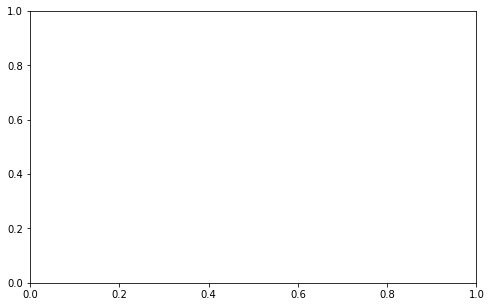

In [286]:
plt.figure(figsize=(8,5))
# plt.title("Validation loss")
plt.plot(best_validation_loss, num_neurons)
plt.xlabel("Validation loss", fontsize=12)
plt.ylabel("Number of neurons", fontsize=12)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

plt.savefig('images/weight matrix - neurons vs loss.eps', dpi=50, format='eps')
plt.show()

plt.figure(figsize=(8,5))
#plt.title("Min angle")
plt.plot(min_angles_neuron, num_neurons[:-1])
plt.xlabel("Minimum angle between units", fontsize=12)
plt.ylabel("Number of neurons", fontsize=12)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

plt.savefig('images/weight matrix - neurons vs min angle.eps', dpi=50, format='eps')
plt.show()


# Train the best model using neuron activation vectors

In [ ]:
def prune_neuron_output_activation_vector(model):
    acts1 = model.acts1.detach().clone()
    acts1 = acts1.T
    # normalise to [-0.5, 0.5]
    acts1 -= 0.5
    vector_angle = torch.zeros(hidden_neurons, hidden_neurons)
    cos = nn.CosineSimilarity(dim=0)
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            vector_angle[i,j] = cos(acts1[i], acts1[j])
    vector_angle = torch.arccos(vector_angle).rad2deg()
    
    # prune the most similar neuron
    min_angle = 180
    for i in range(0, hidden_neurons):
        for j in range(i+1, hidden_neurons):
            if (i not in neurons_to_prune and j not in neurons_to_prune):
                if(vector_angle[i,j] < 15  or vector_angle[i,j] > 165):
                    if(min(vector_angle[i,j], 180 - vector_angle[i,j]) < min_angle):
                        min_angle = min(vector_angle[i,j], 180 - vector_angle[i,j])
                        to_add = i
                        to_prune = j
    if(min_angle != 180):
        min_angles_neuron.append(min_angle)
        if (vector_angle[to_add,to_prune] > 165):    # complementary
            neurons_to_prune.append(to_add)
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] = 0
            model.fc2.weight.data.T[to_add] = 0
            print("Pruned complementary neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        elif(vector_angle[to_add,to_prune] < 15):    # similar
            neurons_to_prune.append(to_prune)
            model.fc1.weight.data[to_add] += model.fc1.weight.data[to_prune]
            print("Pruned similar neuron pair {} - {} : {}".format(to_add, to_prune, vector_angle[to_add,to_prune]))
        model.fc1.weight.data[to_prune] = 0
        model.fc2.weight.data.T[to_prune] = 0
    return min_angle
    

In [ ]:
# # Split dataset into training set and test set
# num_features = train_data.shape[1] - 1

# # split training data into input and target
# # the last column is target and the rest are features
# train_input = train_data.iloc[:, :-1,]
# train_target = train_data.iloc[:, -1:,]

# # split test data into input and target
# # the last column is target and the rest are features
# test_input = test_data.iloc[:, :-1,]
# test_target = test_data.iloc[:, -1::]

# # # create Tensors to hold inputs and outputs
# X = torch.from_numpy(train_input.values).float().to(device)
# Y = torch.from_numpy(train_target.values).long().squeeze().to(device)

# X_test = torch.from_numpy(test_input.values).float().to(device)
# Y_test = torch.from_numpy(test_target.values).long().squeeze().to(device)

# -- Train Model --
# define the number of inputs, classes, training epochs, and learning rate
input_neurons = X.shape[1]
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.01

total_epoch = 0
neurons_to_prune = []
min_angles_neuron = []
train_loss = []
valid_loss = []
best_validation_loss = []

In [ ]:
model = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)
loss_func = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimiser, 'min', factor = 0.5, patience = 10, min_lr=0.001)

In [ ]:
num_epoch = 10000
epoch = 0
# Train a neural network until convergence
converged = False
patience = 25 # for early stopping
while(epoch < num_epoch):
    # Set model to training mode
    model.train()
    Y_pred = model(X)
    optimiser.zero_grad(set_to_none=True)
    loss = loss_func(Y_pred, Y)
    loss.backward()
    optimiser.step()

    train_loss.append(loss.item())
    new_train_loss.append(loss.item())

    
    if converged:
        min_angle = prune_neuron_output_activation_vector(model)
        if(min_angle == 180):
            break
        new_train_loss = []
        new_valid_loss = []
        converged = False

    # Set model to evaluation mode
    model.eval()
    Y_pred_test = model(X_test)
    loss = loss_func(Y_pred_test, Y_test)
    valid_loss.append(loss.item())
    new_valid_loss.append(loss.item())
    
    curr_lr = optimiser.param_groups[0]['lr']
    
    if epoch % 200 == 0 or epoch+1 == num_epoch:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.eq(Y).long().sum()
        print('Epoch [%d] Training Loss: %.4f Validation Loss: %.4f LR: %.4f  Training Accuracy: %.2f %%'
              % (total_epoch + 1, train_loss[len(train_loss)-1], valid_loss[len(valid_loss)-1], curr_lr, 100 * correct/total))
        
    # scheduler.step(loss.item())
    
    if loss.item() == min(valid_loss):
        torch.save({
                    'epoch': total_epoch,
                    'model_state_dict': model.state_dict(),
                    'optimiser_state_dict': optimiser.state_dict(),
                    'loss': loss.item(),
                    'neurons_to_prune': neurons_to_prune
                    }, "best.pt")
    epoch += 1
    total_epoch += 1
    if epoch > patience and loss.item() > new_valid_loss[len(new_valid_loss) - patience]:
        converged = True
        epoch = 0

In [ ]:
test_best_model("best.pt")

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()
plt.figure()
plt.plot(new_train_loss)
plt.plot(new_valid_loss)
plt.show()

___